In [1]:
%load_ext autoreload

In [3]:
import os
import csv
import cv2
from localizer import *
from models import *
from keras.models import *
from keras.layers import *
from keras import callbacks
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm
import h5py
%autoreload

Using TensorFlow backend.


Load Data

In [42]:
def split_dataset(X):
    cutoff_train = int(0.8 * len(X))
    cutoff_val = cutoff_train + int(0.1 * len(X))
    return X[:cutoff_train], X[cutoff_train:cutoff_val], X[cutoff_val:]
def preprocess_image(image):
    # resize 224 x 224 x 3
    image = cv2.resize(image, (224, 224))
    image = image.astype('float32')
    image /= 255.
    return image
def scale_rssi(rssi):
    return (rssi + 100) * (1./70.)
def scale_xy(mapped_values):
    return (mapped_values -10.1) * (1./(59.8-10.1))

In [6]:
lab_localizer = localizer()
lab_localizer.load_profile('test_prof')
print(lab_localizer)

Loaded profile: test_prof
----------------------------------------
Localizer
Wifi Device: wlan0
Profile: test_prof Length: 12
Routers:
    260453955621904
    260453955621906
    260453955621905
    260453955621907
    36168625175133
    48751578567808
    13640875216817
    13640875216818
    13640875216819
    13640875216831
    13640875216829
    13640875216830
----------------------------------------


In [8]:
duck = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/duck.jpg'), cv2.COLOR_BGR2RGB))
tiger = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/tiger.jpg'), cv2.COLOR_BGR2RGB))
beach = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/beach.jpeg'), cv2.COLOR_BGR2RGB))
mountain = preprocess_image(cv2.cvtColor(cv2.imread('../test_images/mountain.jpeg'), cv2.COLOR_BGR2RGB))
xlist = [duck, tiger, beach, mountain]
test_images = np.array(xlist)

In [43]:
def load_data(path, profile=None):
    wifi = []   # (len, num_cells_in_profile)
    mag = []    # (len, 2)
    img = []    # (len, 2, imgx, imgy, imgd)
    xy = []     # (len, 2)
    file_count = 0
    if profile is not None:
        for file_name in os.listdir(path):
            if os.path.isfile(path + file_name):
                print('-- loading from {}'.format(file_name))
                with open(path + file_name, 'r') as f:
                    reader = csv.reader(f)
                    for row in reader:
                        xy.append([float(row[0]), float(row[1])])
                        xy.append([float(row[0]), float(row[1])])
                        mag.append([float(row[2]), float(row[3])])
                        mag.append([float(row[2]), float(row[3])])
                        img1 = cv2.imread(row[5])
                        img1 = preprocess_image(img1)
                        img2 = cv2.imread(row[6])
                        img2 = preprocess_image(img2)
                        img.append(img1)
                        img.append(img2)
                        count = 0
                        wifi_row = []
                        for addr in profile:
                            for cell in row[7:]:
                                mac, rssi = cell.split(' ')
                                if addr == mac:
                                    wifi_row.append(scale_rssi(float(rssi)))
                                    break
                            else:
                                wifi_row.append(scale_rssi(-100.0))
                        wifi.append(wifi_row)
                        wifi.append(wifi_row)
                file_count += 1
        print('Loaded {} files from {}'.format(file_count, path))
        return np.array(wifi), np.array(mag), np.float32(img), np.array(xy)
        
wifi, mag, images, y = load_data('../datasets/', lab_localizer.profile)
mag = mag[:,0]
p = np.random.permutation(len(y))
wifi, mag, images, y = wifi[p], mag[p], images[p], y[p]
# scale mag
mag /= 360.
# scale outputs
y = scale_xy(y)


# CONVERT Y TO 4 DIFFERENT CLASSES
class_dict = {}
count = 0
for i, item in enumerate(y):
    try:
        class_dict[tuple(item)]
    except:
        class_dict[tuple(item)] = count
        count += 1
    images[i] = test_images[class_dict[tuple(item)]]

print(class_dict)
y_cls = np.zeros((y.shape[0], len(class_dict)))
for i in range(len(y)):
    y_cls[i, class_dict[tuple(y[i])]] = 1
    

# BLACKOUT IMAGES FOR TESTING
#images = np.zeros((800, 224, 224, 3))
#
wifi_train, wifi_val, wifi_test = split_dataset(wifi)
mag_train, mag_val, mag_test = split_dataset(mag)
img_train, img_val, img_test = split_dataset(images)
y_train, y_val, y_test = split_dataset(y)
y_cls_train, y_cls_val, y_cls_test = split_dataset(y_cls)
print('Train', y_cls_train.shape)
print('Val', y_cls_val.shape)
print('Test', y_cls_test.shape)

-- loading from 2017-07-24_10:24
Loaded 1 files from ../datasets/
{(0.060362173038229383, 0.5050301810865192): 0, (0.060362173038229383, 0.11267605633802819): 2, (0.99798792756539256, 0.50704225352112675): 1, (0.98993963782696182, 0.10865191146881291): 3}
Train (320, 4)
Val (40, 4)
Test (40, 4)


In [27]:
from keras.applications.vgg16 import VGG16
from keras.preprocessing import image
from keras.applications.vgg16 import preprocess_input

In [28]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.trainable = False

vgg.summary()
#images_test = preprocess_input(images_test)
#images_train = preprocess_input(images_train)

#features = model.predict(images_train)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [53]:
# define model inputs
wifi_input = Input(shape=(12,), dtype='float32')
mag_input = Input(shape=(1,), dtype='float32')
img_input = Input(shape=(224, 224, 3), dtype='float32')

wifi_branch = Dense(64, activation='relu')(wifi_input)

mag_branch = Dense(16, activation='relu')(mag_input)

img_branch = vgg(img_input)
img_branch = Flatten()(img_branch)

#merged = concatenate([wifi_branch, mag_branch, img_branch], axis=-1)
merged = concatenate([wifi_branch, mag_branch], axis=-1)
merged = Dense(16, activation='relu')(merged)
merged = Dense(16, activation='relu')(merged)
merged = Dense(16, activation='relu')(merged)
#out = Dense(2, activation='linear')(merged)
out = Dense(4, activation='softmax')(merged)

#model = Model([wifi_input, mag_input, img_input], out)
model = Model([wifi_input, mag_input], out)

#model.compile(optimizer='rmsprop', loss='mse')
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_18 (InputLayer)            (None, 12)            0                                            
____________________________________________________________________________________________________
input_19 (InputLayer)            (None, 1)             0                                            
____________________________________________________________________________________________________
dense_32 (Dense)                 (None, 64)            832         input_18[0][0]                   
____________________________________________________________________________________________________
dense_33 (Dense)                 (None, 16)            32          input_19[0][0]                   
___________________________________________________________________________________________

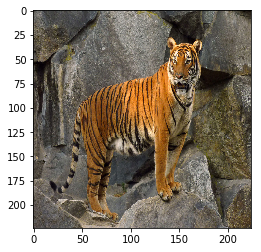

In [54]:
plt.imshow(img_train[4])

In [55]:
batch_size = 50
epochs = 100
model_name = 'test_model'
if not os.path.exists('../models/' + model_name):
    os.makedirs('../models/' + model_name)

#Save the model after each epoch if the validation loss improved.
save_best = callbacks.ModelCheckpoint('../models/' + model_name + '/' + model_name + '.hdf5', monitor='val_loss', verbose=1, 
                                     save_best_only=True, mode='min')

#stop training if the validation loss doesn't improve for 5 consecutive epochs.
early_stop = callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, 
                                     verbose=0, mode='auto')

callbacks_list = [save_best, early_stop]


In [57]:
train_data = [wifi_train, mag_train]
val_data = ([wifi_val, mag_val], y_cls_val)
test_data = [wifi_test, mag_test]

In [58]:
model.fit(train_data, y_cls_train, epochs=epochs, batch_size=batch_size, validation_data=val_data, callbacks=callbacks_list)
print(model.evaluate(test_data, y_cls_test, batch_size=batch_size))


Train on 320 samples, validate on 40 samples
Epoch 1/100
320/320 [==============================] - 0s - loss: 1.3784 - acc: 0.2156 - val_loss: 1.3635 - val_acc: 0.5250
Epoch 2/100
320/320 [==============================] - 0s - loss: 1.3559 - acc: 0.3781 - val_loss: 1.3426 - val_acc: 0.6750
Epoch 3/100
320/320 [==============================] - 0s - loss: 1.3363 - acc: 0.5844 - val_loss: 1.3211 - val_acc: 0.6250
Epoch 4/100
320/320 [==============================] - 0s - loss: 1.3117 - acc: 0.6469 - val_loss: 1.2964 - val_acc: 0.6000
Epoch 5/100
320/320 [==============================] - 0s - loss: 1.2849 - acc: 0.6125 - val_loss: 1.2684 - val_acc: 0.5000
Epoch 6/100
320/320 [==============================] - 0s - loss: 1.2544 - acc: 0.5437 - val_loss: 1.2377 - val_acc: 0.5250
Epoch 7/100
320/320 [==============================] - 0s - loss: 1.2219 - acc: 0.6250 - val_loss: 1.2074 - val_acc: 0.5250
Epoch 8/100
320/320 [==============================] - 0s - loss: 1.1854 - acc: 0.5969 

320/320 [==============================] - 0s - loss: 0.3308 - acc: 0.9781 - val_loss: 0.3120 - val_acc: 1.0000
Epoch 28/100
320/320 [==============================] - 0s - loss: 0.2999 - acc: 0.9844 - val_loss: 0.2822 - val_acc: 0.9750
Epoch 29/100
320/320 [==============================] - 0s - loss: 0.2717 - acc: 0.9813 - val_loss: 0.2743 - val_acc: 0.9750
Epoch 30/100
320/320 [==============================] - 0s - loss: 0.2486 - acc: 0.9813 - val_loss: 0.2279 - val_acc: 1.0000
Epoch 31/100
320/320 [==============================] - 0s - loss: 0.2240 - acc: 0.9844 - val_loss: 0.2259 - val_acc: 0.9750
Epoch 32/100
320/320 [==============================] - 0s - loss: 0.2065 - acc: 0.9812 - val_loss: 0.1792 - val_acc: 1.0000
Epoch 33/100
320/320 [==============================] - 0s - loss: 0.1854 - acc: 0.9875 - val_loss: 0.1726 - val_acc: 0.9750
Epoch 34/100
320/320 [==============================] - 0s - loss: 0.1723 - acc: 0.9812 - val_loss: 0.1491 - val_acc: 1.0000
Epoch 35/100


320/320 [==============================] - 0s - loss: 0.0531 - acc: 0.9875 - val_loss: 0.0307 - val_acc: 1.0000
Epoch 56/100
320/320 [==============================] - 0s - loss: 0.0558 - acc: 0.9844 - val_loss: 0.0412 - val_acc: 1.0000
Epoch 57/100
320/320 [==============================] - 0s - loss: 0.0476 - acc: 0.9875 - val_loss: 0.0488 - val_acc: 0.9750
Epoch 58/100
320/320 [==============================] - 0s - loss: 0.0512 - acc: 0.9875 - val_loss: 0.0235 - val_acc: 1.0000
Epoch 59/100
320/320 [==============================] - 0s - loss: 0.0479 - acc: 0.9875 - val_loss: 0.0349 - val_acc: 1.0000
Epoch 60/100
320/320 [==============================] - 0s - loss: 0.0456 - acc: 0.9844 - val_loss: 0.0276 - val_acc: 1.0000
Epoch 61/100
320/320 [==============================] - 0s - loss: 0.0417 - acc: 0.9875 - val_loss: 0.0682 - val_acc: 0.9750
Epoch 62/100
320/320 [==============================] - 0s - loss: 0.0458 - acc: 0.9844 - val_loss: 0.0574 - val_acc: 0.9750
Epoch 63/100


In [59]:
model.predict(images_test[3:4])

ValueError: The model expects 2 arrays, but only received one array. Found: array with shape (1, 224, 224, 3)

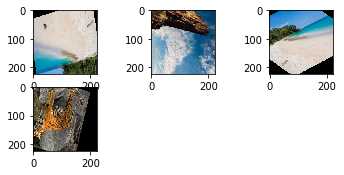

Epoch 1/100
7/6 [================================] - 2s - loss: 7.0070e-06 - acc: 1.0000 - val_loss: 8.5708e-06 - val_acc: 1.0000
Epoch 2/100
7/6 [================================] - 2s - loss: 1.3757e-06 - acc: 1.0000 - val_loss: 1.2569e-04 - val_acc: 1.0000
Epoch 3/100
7/6 [================================] - 2s - loss: 3.3997e-06 - acc: 1.0000 - val_loss: 2.2203e-06 - val_acc: 1.0000
Epoch 4/100
7/6 [================================] - 2s - loss: 7.2681e-04 - acc: 1.0000 - val_loss: 0.7796 - val_acc: 0.8000
Epoch 5/100
7/6 [================================] - 2s - loss: 0.1024 - acc: 0.9711 - val_loss: 3.2963e-05 - val_acc: 1.0000
Epoch 6/100
7/6 [================================] - 2s - loss: 0.0011 - acc: 1.0000 - val_loss: 8.2891e-06 - val_acc: 1.0000
Epoch 7/100
7/6 [================================] - 2s - loss: 3.6838e-05 - acc: 1.0000 - val_loss: 1.0535e-06 - val_acc: 1.0000
Epoch 8/100
7/6 [================================] - 2s - loss: 5.3143e-06 - acc: 1.0000 - val_loss: 3

In [47]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    zca_whitening=False,
    rotation_range=180,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.5,
    fill_mode='constant',
    horizontal_flip=False,
    vertical_flip=False)

train_datagen.fit(images_train)

val_datagen = train_datagen

for X_batch, y_batch in datagen.flow(images_train, y_cls_train):
    for i in range(0, 4):
        plt.subplot(330 + 1 + i)
        plt.imshow(X_batch[i])
    plt.show()
    break

model.fit_generator(datagen.flow(img_train, y_cls_train, batch_size=batch_size), 
                    steps_per_epoch=len(img_train) / batch_size, epochs=epochs,
                    validation_data=val_datagen.flow(img_val, y_cls_val, batch_size=batch_size), 
                    validation_steps=len(img_val) / batch_size,
                    callbacks=callbacks_list)
print(model.evaluate(img_test, y_cls_test, batch_size=batch_size))

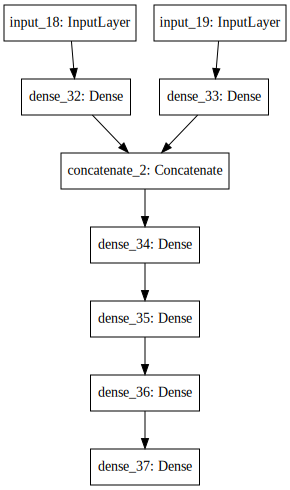

In [60]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

SVG(model_to_dot(model).create(prog='dot', format='svg'))

Visualize

In [50]:
def plot_predictions(model, figure_name, x_vals, y_vals, eval_range=.1):
    # generate color dictionary
    unique_collection_points = []
    for loc in y_vals:
        point = tuple(loc)
        if point not in unique_collection_points:
            unique_collection_points.append(point)
    for loc in y_vals:
        point = tuple(loc)
        if point not in unique_collection_points:
            unique_collection_points.append(point)
    num_points = len(unique_collection_points)
 
    color_map_iter = iter(cm.rainbow(np.linspace(0, 1, num_points)))
    colors = {}
    for loc in y_vals:
        try:
            colors[tuple(loc)]
        except:
            colors[tuple(loc)] = next(color_map_iter)
            
    # plot points
    correct_points = 0
    ax = plt.gca()
    pred_set = model.predict(x_vals, verbose=0)
    for i, point in enumerate(pred_set):
        color = colors[tuple(y_vals[i])]
        plt.scatter(point[0], point[1], color=color)
        # compute the distance to the target
        x_diff = point[0] - y_vals[i,0]
        y_diff = point[1] - y_vals[i,1]
        dist = np.sqrt(np.square(x_diff) + np.square(y_diff))
        if dist < eval_range:
            correct_points += 1
    # plot acceptable range circles
    for item in colors:
        plt.scatter(float(item[0]), float(item[1]), color='black', marker='x')
        rect = patches.Circle((float(item[0]), float(item[1])),
                              radius=eval_range,linewidth=2,edgecolor='k',facecolor='none')
        ax.add_patch(rect)
    plt.title('{} \nCorrect Predictions: {}/{} {:.2f}%'.format(figure_name, correct_points, len(pred_set), 
                                                  100*float(correct_points)/float(len(pred_set))))
    
    plt.savefig(figure_name)
    plt.show()
    

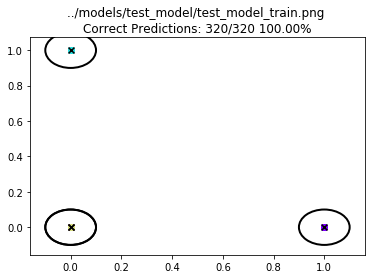

In [51]:
plot_predictions(model, '../models/' + model_name + '/' + model_name + '_train.png', 
                 [img_train], y_cls_train)

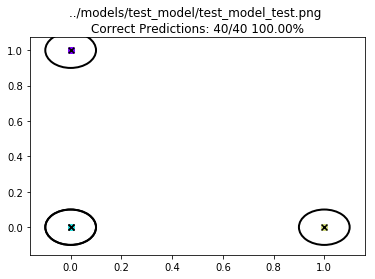

In [52]:
plot_predictions(model, '../models/' + model_name + '/' + model_name + '_test.png', 
                 [img_test], y_cls_test)